In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib
import pickle
from scipy.stats import median_abs_deviation, hypergeom
import math

In [2]:
from utils_custom import *
from local_dynamics import *

In [3]:
# Paths
dictys_dynamic_object_path = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/dynamic.h5"
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/pb_98'
latent_factor_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors'
lf_blimp1_file = f"{latent_factor_folder}/feature_list_Z5_PRDM1_KO.txt"
lf_irf4_file = f"{latent_factor_folder}/feature_list_Z4_IRF4_KO.txt"

In [4]:
lf_blimp1 = pd.read_csv(lf_blimp1_file, sep='\t')['names'].tolist()
lf_irf4 = pd.read_csv(lf_irf4_file, sep='\t')['names'].tolist()

In [ ]:
def run_episode(
    episode_idx,
    dictys_dynamic_object_path,
    output_folder,
    latent_factor_folder,
    time_slice_start,
    time_slice_end,
    lf_genes,
    percentile=98
):
    # Load dictys object inside the process
    dictys_dynamic_object = dictys.net.dynamic_network.from_file(dictys_dynamic_object_path)
    epi = episode_dynamics(
        dictys_dynamic_object=dictys_dynamic_object,
        output_folder=output_folder,
        latent_factor_folder=latent_factor_folder,
        trajectory_range=(1, 2),  # branch would give why cells are going down there
        num_points=40,
        dist=0.001,
        sparsity=0.01
    )
    epi.compute_expression_curves()
    epi.set_lf_genes(lf_genes)
    # time slice is the number of windows in the episode based on the sampled num_points
    epi.build_episode_grn(time_slice=slice(time_slice_start, time_slice_end))
    epi.filter_edges()
    epi.compute_tf_expression()
    epi.calculate_forces()
    epi.select_top_edges(percentile)
    epi.annotate_lf_in_grn()
    enrichment_df = epi.calculate_enrichment()
    # save to CSV
    out_path = os.path.join(output_folder, f'enrichment_episode_{episode_idx}.csv')
    enrichment_df.to_csv(out_path, index=False)
    return out_path

In [ ]:
run_episode(
    episode_idx=8,
    dictys_dynamic_object_path=dictys_dynamic_object_path,
    output_folder=output_folder,
    latent_factor_folder=latent_factor_folder,
    time_slice_start=36,
    time_slice_end=40,
    lf_genes=lf_irf4
)
# why are time cols only 4 instead of 5?

Processing 980,023 rows using 16 processes...
Chunk size: 8,000 rows
Direction invariance check: Enabled
Time columns: ['time_0', 'time_1', 'time_2', 'time_3']
Creating index chunks...
Created 123 chunks of indices


Processing chunks: 100%|██████████| 123/123 [01:13<00:00,  1.68it/s]


Processing completed in 73.90 seconds
Sorting results...
Creating result DataFrame...
Processing 330,882 edges using 20 processes...
Chunk size: 30,000 rows
Time columns: ['time_0', 'time_1', 'time_2', 'time_3']
Beta curves shape: (330882, 4)
TF expression shape: (313, 4)
Created 11 chunks
Chunk sizes: [30081, 30081, 30080, 30080, 30080]...


Processing chunks: 100%|██████████| 11/11 [00:01<00:00,  9.92it/s]


Processing completed in 1.86 seconds
Combining results...
Final shape: (330882, 4)


'/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/irf4_ko/pb_98/enrichment_episode_8.csv'

# Un-parallelized version

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(dictys_dynamic_object_path)

### Expression dynamics

In [6]:
# get lcpm chars for these genes
lcpm_dcurve, dtime = compute_expression_regulation_curves(dictys_dynamic_object, start=1, stop=3, num=40, dist=0.001, mode="expression")
# remove genes with names starting with ZNF and ZBTB
lcpm_dcurve = lcpm_dcurve[~lcpm_dcurve.index.str.startswith('ZNF') & ~lcpm_dcurve.index.str.startswith('ZBTB')]
# get lcpm chars for these genes
#lcpm_dcurve_gc, dtime_gc = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=20, dist=0.001, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
display(lcpm_dcurve.head())

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
A1BG,4.155221,4.170672,4.186634,4.203052,4.219861,4.236983,4.254330,4.271800,4.289273,4.306614,...,4.165388,4.147355,4.132847,4.121469,4.112746,4.106199,4.101390,4.097944,4.095549,4.093957
A1BG-AS1,3.620198,3.623879,3.627706,3.631671,3.635768,3.639987,3.644317,3.648745,3.653257,3.657838,...,3.744351,3.746146,3.747664,3.748939,3.750005,3.750892,3.751625,3.752227,3.752714,3.753101
AAAS,4.605135,4.601931,4.598233,4.594046,4.589384,4.584273,4.578746,4.572852,4.566651,4.560224,...,4.722776,4.735847,4.746097,4.753841,4.759452,4.763303,4.765736,4.767046,4.767476,4.767224
AACS,4.004986,4.036881,4.069677,4.103297,4.137661,4.172683,4.208282,4.244379,4.280905,4.317806,...,5.104201,5.116823,5.126365,5.133484,5.138752,5.142634,5.145495,5.147611,5.149186,5.150371
AAGAB,5.743944,5.745945,5.747973,5.750020,5.752081,5.754151,5.756227,5.758306,5.760391,5.762487,...,5.925421,5.935478,5.944243,5.951820,5.958349,5.963979,5.968854,5.973103,5.976835,5.980144


### Regulation dynamics


In [7]:
pts, fsmooth = dictys_dynamic_object.linspace(1,3,40,0.001)
stat1_net = fsmooth(stat.net(dictys_dynamic_object)) #varname=w_in loads total effect network
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

# Get episode specific GRN (transient state specific)

In [8]:
# pts is a dictys traj object
dnetbin = stat1_netbin.compute(pts)
dnetbin_episode = dnetbin[:, :, 0:5] #5 timepoints, excludes the last one

In [9]:
# compute the weighted network
dnet = stat1_net.compute(pts)
dnet_episode = dnet[:, :, 0:5]
display(dnet_episode)

array([[[ 1.48228023e-03,  1.89361302e-03,  2.33167382e-03,
          2.79365931e-03,  3.27576725e-03],
        [-8.83021283e-03, -9.50342901e-03, -1.02073752e-02,
         -1.09409778e-02, -1.17029892e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 4.16719221e-02,  4.45715324e-02,  4.76299534e-02,
          5.08415733e-02,  5.41988228e-02],
        [ 1.91637947e-02,  1.87549643e-02,  1.83524690e-02,
          1.79596842e-02,  1.75802310e-02]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.0000000

### Filter episodic GRN edges which are significantly non-zero across time points and are direction invariant

In [10]:
###### Get the tf and target names #####
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
target_names = [index_to_gene[idx] for idx in range(dnetbin_episode.shape[1])]
# Get TF_gene_indices from TFs_to_keep_indices using nids[0]
tf_gene_indices = [dictys_dynamic_object.nids[0][tf_idx] for tf_idx in range(dnetbin_episode.shape[0])]
tf_names = [index_to_gene[idx] for idx in tf_gene_indices]
print(len(target_names))
print(len(tf_names))

11907
551


In [11]:
###### Create multi-index tuples (all combinations of TF-target pairs) ######
index_tuples = [(tf, target) for tf in tf_names for target in target_names]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = dnet_episode.shape
reshaped_data = dnet_episode.reshape(-1, n_times)
# Create DataFrame with multi-index
episode_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
# drop rows that are all 0
episode_beta_dcurve = episode_beta_dcurve[episode_beta_dcurve.sum(axis=1) != 0]
# the number of edges here remain the same between episodes, indicating that exact 0 are the edges that don't have atac-seq basis
display(episode_beta_dcurve.head())
display(episode_beta_dcurve.shape)

time_0    time_1    time_2    time_3    time_4
TF  Target                                                    
AHR A1BG      0.001482  0.001894  0.002332  0.002794  0.003276
    A1BG-AS1 -0.008830 -0.009503 -0.010207 -0.010941 -0.011703
    AAGAB     0.002089  0.001988  0.001887  0.001785  0.001683
    AAK1      0.031886  0.034223  0.036661  0.039196  0.041819
    AAMDC     0.006296  0.006446  0.006579  0.006694  0.006789

(1471590, 5)

In [12]:
###### Filtering the global episodic GRN for retaining significantly non-zero and direction invariant edges ######
filtered_edges = filter_edges_by_significance_and_direction(
    episode_beta_dcurve,
    min_nonzero_timepoints=3,
    alpha=0.05,
    min_observations=3,
    check_direction_invariance=True,  # Enable direction invariance check
    n_processes=60,
    chunk_size=8000,
    save_intermediate=False,
    intermediate_path=output_folder
)
    
print(f"\nFinal shape: {filtered_edges.shape}")

Processing 1,471,590 rows using 60 processes...
Chunk size: 8,000 rows
Direction invariance check: Enabled
Time columns: ['time_0', 'time_1', 'time_2', 'time_3', 'time_4']
Creating index chunks...
Created 184 chunks of indices


Processing chunks: 100%|██████████| 184/184 [00:42<00:00,  4.34it/s]


Processing completed in 44.81 seconds
Sorting results...
Creating result DataFrame...

Final shape: (1437301, 6)


In [13]:
# load episode parquet file into pandas
#filtered_edges = pd.read_parquet('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/filtered_edges_significant_invariant_PB_ep4.parquet')
# remove TFs starting with ZNF or ZBTB
filtered_edges = filtered_edges[~filtered_edges.index.get_level_values(0).str.startswith('ZNF') & ~filtered_edges.index.get_level_values(0).str.startswith('ZBTB')]
display(filtered_edges)

time_0    time_1    time_2    time_3    time_4  \
TF      Target                                                       
AHR     A1BG      0.001482  0.001894  0.002332  0.002794  0.003276   
        A1BG-AS1 -0.008830 -0.009503 -0.010207 -0.010941 -0.011703   
        AAGAB     0.002089  0.001988  0.001887  0.001785  0.001683   
        AAK1      0.031886  0.034223  0.036661  0.039196  0.041819   
        AAMDC     0.006296  0.006446  0.006579  0.006694  0.006789   
...                    ...       ...       ...       ...       ...   
ZSCAN30 ZXDC     -0.000357 -0.000337 -0.000317 -0.000297 -0.000277   
        ZYG11B   -0.004645 -0.004682 -0.004722 -0.004762 -0.004804   
        ZZEF1    -0.006699 -0.006320 -0.005944 -0.005573 -0.005209   
ZSCAN9  AGFG1     0.000002  0.000003  0.000004  0.000006  0.000009   
        MFF       0.000001  0.000002  0.000002  0.000003  0.000005   

                       p_value  
TF      Target                  
AHR     A1BG      1.760649e-03  
        A1BG-AS1  3.581517e-05  
        AAGAB     1.243935e-05  
        AAK1      3.083673e-05  
        AAMDC     1.900024e-07  
...                        ...  
ZSCAN30 ZXDC      2.319785e-05  
        ZYG11B    7.495682e-09  
        ZZEF1     2.281713e-05  
ZSCAN9  AGFG1     1.784718e-02  
        MFF       1.785313e-02  

[962247 rows x 6 columns]

In [14]:
# drop edges with p_value > 0.01
filtered_edges_p001 = filtered_edges[filtered_edges['p_value'] < 0.001]
display(filtered_edges_p001.head())
display(filtered_edges_p001.shape)

time_0    time_1    time_2    time_3    time_4       p_value
TF  Target                                                                  
AHR A1BG-AS1 -0.008830 -0.009503 -0.010207 -0.010941 -0.011703  3.581517e-05
    AAGAB     0.002089  0.001988  0.001887  0.001785  0.001683  1.243935e-05
    AAK1      0.031886  0.034223  0.036661  0.039196  0.041819  3.083673e-05
    AAMDC     0.006296  0.006446  0.006579  0.006694  0.006789  1.900024e-07
    AAMP      0.007576  0.008064  0.008565  0.009078  0.009602  1.805246e-05

(787496, 6)

## Get TF forces for the episode & State

In [22]:
###### CHANGE STATE HERE ######
tf_lcpm_values = lcpm_dcurve.loc[filtered_edges_p001.index.get_level_values(0).unique()]
display(tf_lcpm_values.shape)
###### CHANGE EPISODE HERE ######
tf_lcpm_episode = tf_lcpm_values.iloc[:, 15:20]

# Adaptive column renaming to match beta curves
beta_time_cols = [col for col in filtered_edges_p001.columns if col.startswith('time_')]
n_time_cols = len(beta_time_cols)

# Rename TF expression columns to match beta curves format
tf_lcpm_episode.columns = beta_time_cols[:n_time_cols]
display(tf_lcpm_episode)

(320, 40)

,time_0,time_1,time_2,time_3,time_4
TF,,,,,
AHR,6.978056,7.022876,7.071520,7.124631,7.182801
ARID3A,6.567111,6.615728,6.664128,6.712121,6.759376
ARID3B,6.072547,6.124243,6.178684,6.236211,6.297040
ARID5A,6.186670,6.235584,6.286372,6.339509,6.395396
ARID5B,8.818349,8.844242,8.868468,8.890813,8.911036
...,...,...,...,...,...
ZKSCAN5,3.485340,3.505502,3.527305,3.551032,3.576950
ZKSCAN7,1.469201,1.450184,1.429492,1.406681,1.381314
ZSCAN26,2.684175,2.686956,2.692041,2.699767,2.710469


In [16]:
# Prepare beta curves (only time columns)
beta_curves_for_force = filtered_edges_p001.drop('p_value', axis=1)

print("Starting parallel force calculation...")
print(f"Input beta curves shape: {beta_curves_for_force.shape}")
print(f"TF expression shape: {tf_lcpm_episode.shape}")

# Calculate forces in parallel
force_curves = calculate_force_curves_parallel(
    beta_curves=beta_curves_for_force,
    tf_expression=tf_lcpm_episode,
    n_processes=20,  # Adjust based on your system
    chunk_size=30000,  # Adjust based on available memory
    epsilon=1e-10,
    save_intermediate=False
)

print(f"Force calculation completed!")
print(f"Output shape: {force_curves.shape}")
# Display sample results
display(force_curves.head())

Starting parallel force calculation...
Input beta curves shape: (787496, 5)
TF expression shape: (320, 5)
Processing 787,496 edges using 20 processes...
Chunk size: 30,000 rows
Time columns: ['time_0', 'time_1', 'time_2', 'time_3', 'time_4']
Beta curves shape: (787496, 5)
TF expression shape: (320, 5)
Created 26 chunks
Chunk sizes: [30289, 30289, 30289, 30289, 30289]...


Processing chunks: 100%|██████████| 26/26 [00:02<00:00, 11.66it/s]


Processing completed in 3.06 seconds
Combining results...
Final shape: (787496, 5)
Force calculation completed!
Output shape: (787496, 5)


time_0    time_1    time_2    time_3    time_4
TF  Target                                                    
AHR A1BG-AS1 -0.289867 -0.299641 -0.309500 -0.319427 -0.329404
    AAGAB     0.154987  0.151890  0.148672  0.145339  0.141897
    AAK1      0.506262  0.522705  0.539289  0.555970  0.572698
    AAMDC     0.250272  0.253149  0.255748  0.258048  0.260033
    AAMP      0.271213  0.279016  0.286799  0.294557  0.302283

#### Get the average force over the episode

In [17]:
# Calculate average force over the 5 time points
avg_force = force_curves.mean(axis=1)
print(f"Average force shape: {avg_force.shape}")
# Convert to DataFrame with proper column name
avg_force_df = avg_force.to_frame(name='avg_force')
display(avg_force_df.head())

Average force shape: (787496,)


avg_force
TF  Target             
AHR A1BG-AS1  -0.309568
    AAGAB      0.148557
    AAK1       0.539385
    AAMDC      0.255450
    AAMP       0.286774

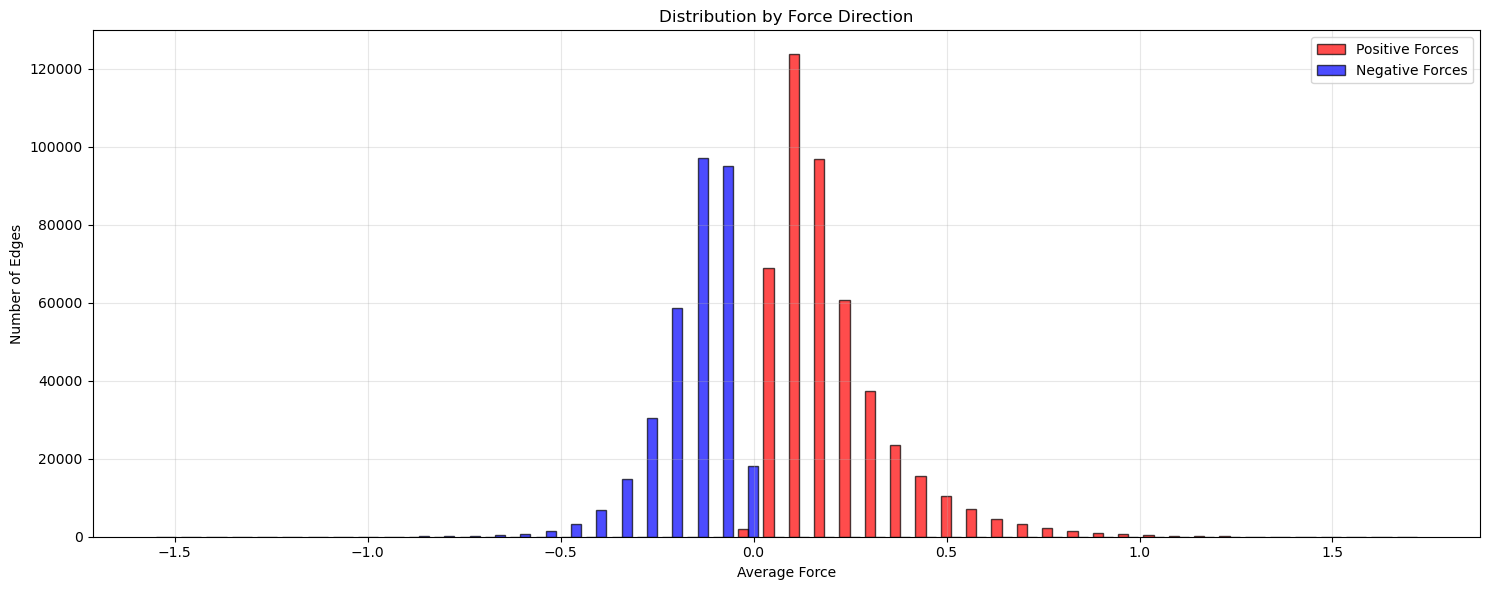

In [18]:
# Plot distribution
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

# Separate positive and negative forces
positive_forces = avg_force[avg_force > 0]
negative_forces = avg_force[avg_force < 0]

axes.hist([positive_forces, negative_forces], bins=50, alpha=0.7, 
              color=['red', 'blue'], label=['Positive Forces', 'Negative Forces'], edgecolor='black')
axes.set_xlabel('Average Force')
axes.set_ylabel('Number of Edges')
axes.set_title('Distribution by Force Direction')
axes.legend()
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
import numpy as np
import pandas as pd

if len(positive_forces) > 0:
    pos_threshold = np.percentile(positive_forces, 98)
    top_pos_edges = positive_forces[positive_forces >= pos_threshold]
else:
    top_pos_edges = pd.Series(dtype=avg_force.dtype)

if len(negative_forces) > 0:
    neg_threshold = np.percentile(negative_forces, 0.5)
    top_neg_edges = negative_forces[negative_forces <= neg_threshold]
else:
    top_neg_edges = pd.Series(dtype=avg_force.dtype)

# Combine into a DataFrame
episodic_grn_edges = pd.concat([top_pos_edges, top_neg_edges]).to_frame(name='avg_force')

# Optionally, sort by force value (descending for positive, ascending for negative)
episodic_grn_edges = episodic_grn_edges.sort_values(by='avg_force', ascending=False)

# Display or use as needed
print(episodic_grn_edges)
print(f"Number of positive edges: {len(top_pos_edges)}")
print(f"Number of negative edges: {len(top_neg_edges)}")
print(f"Total selected edges: {len(episodic_grn_edges)}")
# display the unique tf and target numbers
display(len(episodic_grn_edges.index.get_level_values(0).unique()))
display(len(episodic_grn_edges.index.get_level_values(1).unique()))

               avg_force
TF     Target           
POU6F1 MBD2     1.725465
CTCF   TUBA1B   1.555561
MBD2   SET      1.540263
RELB   REL      1.532793
TCF12  DLEU2    1.467997
...                  ...
TFDP1  IRF3    -1.323698
ELF2   ZNF846  -1.353244
CTCF   TFE3    -1.467457
NR6A1  IRF2    -1.515770
TCF12  ZNF846  -1.556472

[10840 rows x 1 columns]
Number of positive edges: 9202
Number of negative edges: 1638
Total selected edges: 10840


255

4063

#### Select the top k% of edges to build the episodic GRN

## Get the TFs acting on LF genes

In [30]:
# load LF files 
z11_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z11_GC_PB.txt'
z3_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z3_GC_PB.txt'
z_prdm1_ko = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z5_PRDM1_KO.txt"
# load into a list of gene names 
z11 = pd.read_csv(z11_file, sep='\t', header=0)
z3 = pd.read_csv(z3_file, sep='\t', header=0)
z_prdm1_ko = pd.read_csv(z_prdm1_ko, sep='\t', header=0)
# remove HLA- genes
z11 = z11[~z11['names'].str.contains('HLA-')]
z3 = z3[~z3['names'].str.contains('HLA-')]
z_prdm1_ko = z_prdm1_ko[~z_prdm1_ko['names'].str.contains('HLA-')]

In [31]:
# get the gene names 
z11_genes = z11['names'].tolist()
z3_genes = z3['names'].tolist()
z_prdm1_ko_genes = z_prdm1_ko['names'].tolist()
# create a list of all lf genes 
#lf_genes = list(set(z11_genes + z3_genes))
lf_genes = list(set(z_prdm1_ko_genes))
lf_in_object = check_if_gene_in_ndict(dictys_dynamic_object, lf_genes, return_index=True)
print(f"Found {len(lf_in_object['present'])} genes")
print(f"Missing {len(lf_in_object['missing'])} genes")
print("Indices:", lf_in_object['indices'])

Found 40 genes
Missing 0 genes
Indices: {'NDUFB5': 6364, 'CNPY3': 2010, 'FOXK1': 3529, 'CYB561A3': 2308, 'PNISR': 7385, 'FUT8': 3589, 'NAA38': 6218, 'OCIAD1': 6750, 'TGFB1': 10018, 'ARHGAP42': 592, 'PINX1': 7245, 'BCAP31': 937, 'PPM1D': 7523, 'FOXJ3': 3528, 'PRKAR1B': 7641, 'TMEM248': 10257, 'NSUN5': 6648, 'ADARB1': 182, 'PDLIM5': 7051, 'PACC1': 6868, 'RRP9': 8547, 'MTG2': 6090, 'NIBAN3': 6471, 'NT5C': 6651, 'AIP': 285, 'VAPA': 10994, 'MYBL2': 6150, 'STK33': 9653, 'SPIB': 9476, 'DPYSL2': 2739, 'ANAPC4': 392, 'RBM38': 8108, 'BABAM1': 894, 'STX7': 9696, 'NEK6': 6405, 'EMC3': 3006, 'PVT1': 7864, 'KCTD13': 4815, 'RCL1': 8150, 'LZIC': 5445}


#### Get the enrichment (over representation) of LF genes in TF regulons

In [32]:
# add a boolean column indicating if the target is a lf gene in the episodic grn df
episodic_grn_edges['is_in_lf'] = episodic_grn_edges.index.get_level_values(1).isin(lf_genes)
# get the number of genes in the episodic grn edges
target_genes_in_episodic_grn = episodic_grn_edges.index.get_level_values(1).unique()
display("Number of targets in episodic grn: ", len(target_genes_in_episodic_grn))
# get the number of lf_genes in the episodic grn edges
lf_in_episodic_grn = episodic_grn_edges[episodic_grn_edges['is_in_lf']]
display(lf_in_episodic_grn.head())
# get the unique LF genes active in the lf_in_episodic_grn df
lf_genes_active_in_episode = lf_in_episodic_grn.index.get_level_values(1).unique()
display("Number of LF genes active in episode: ", len(lf_genes_active_in_episode))
tfs_acting_on_lf = lf_in_episodic_grn.index.get_level_values(0).unique()
display("TFs acting on LF genes: ", tfs_acting_on_lf, len(tfs_acting_on_lf))
# take the tfs in the lf_in_episodic_grn df and subset the episodic_grn_edges df to only include these tfs
episodic_grn_edges_subset = episodic_grn_edges[episodic_grn_edges.index.get_level_values(0).isin(lf_in_episodic_grn.index.get_level_values(0))]
display(episodic_grn_edges_subset.head())
display(episodic_grn_edges_subset.shape)

'Number of targets in episodic grn: '

3534

,,avg_force,is_in_lf
TF,Target,,
ELK3,SPIB,1.186223,True
MBD2,VAPA,1.074982,True
HNF1B,PNISR,1.006893,True
IRF8,PVT1,0.985759,True
EGR3,FOXJ3,0.981364,True


'Number of LF genes active in episode: '

19

'TFs acting on LF genes: '

Index(['ELK3', 'MBD2', 'HNF1B', 'IRF8', 'EGR3', 'FLI1', 'BPTF', 'GABPA', 'SP4',
       'TCF4', 'SP3', 'ELK4', 'IRF4', 'IKZF1', 'ERF', 'SP1', 'ETS1', 'TFDP1',
       'RFX3', 'POU2F2', 'AHR', 'STAT3', 'CTCF', 'YBX3', 'MECP2', 'TFE3',
       'IRF2', 'NFAT5', 'NRF1'],
      dtype='object', name='TF')

29

avg_force  is_in_lf
TF    Target                     
CTCF  TUBA1B   1.555561     False
MBD2  SET      1.540263     False
CTCF  TUBA1C   1.459746     False
IKZF1 SRRM1    1.458549     False
      FCHSD2   1.452873     False

(4518, 2)

In [34]:
episodic_enrichment_df = calculate_tf_episodic_enrichment(episodic_grn_edges_subset, 
                                       len(lf_genes_active_in_episode), 
                                       len(target_genes_in_episodic_grn))
# sort the episodic_enrichment_df_p005 by enrichment_score in descending order
episodic_enrichment_df_sorted = episodic_enrichment_df.sort_values(by='enrichment_score', ascending=False)
# filter the episodic_enrichment_df to only include tfs with a p_value < threshold
episodic_enrichment_df_p005 = episodic_enrichment_df_sorted[episodic_enrichment_df_sorted['p_value'] < 0.05]
display(episodic_enrichment_df_p005)

,TF,p_value,enrichment_score,genes_in_lf,genes_dwnstrm,weights
26,EGR3,0.010725,93.000000,"(FOXJ3,)","(ELF1,)","(0.9813640104609048,)"
7,TFE3,0.026609,37.200000,"(FOXJ3,)","(CTCF, JUNB, PRDM1, DDX21)","(0.7311260525410564,)"
28,SP1,0.031850,31.000000,"(FOXJ3,)","(NFYC, FOXN2, YBX1, GAPDH, ELK4)","(0.8015307766780644,)"
23,BPTF,0.013095,11.272727,"(PNISR, TMEM248)","(SIL1, POLA1, UBE2D2, PLEKHG1, SNRPA1, RAB2A, ...","(0.9138079350883705, 0.7550203214211731)"
3,MECP2,0.015326,5.580000,"(PNISR, STX7, NIBAN3)","(SP1, TCF12, ELF2, SP4, TFDP1, STAT3, ELK4, KL...","(0.7399874208710921, -0.599370524430595, -0.65..."


In [36]:
# save the episodic_enrichment_df_p005_sorted df to a csv file
episodic_enrichment_df_sorted.to_csv(os.path.join(output_folder, 'enrichment_ep1_blimp_ko.csv'), index=False)